In [524]:
import folium
import json
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup
from bs4 import BeautifulSoup
import requests
import geopandas
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from datetime import datetime as dt
from statsmodels.tsa.api import ExponentialSmoothing

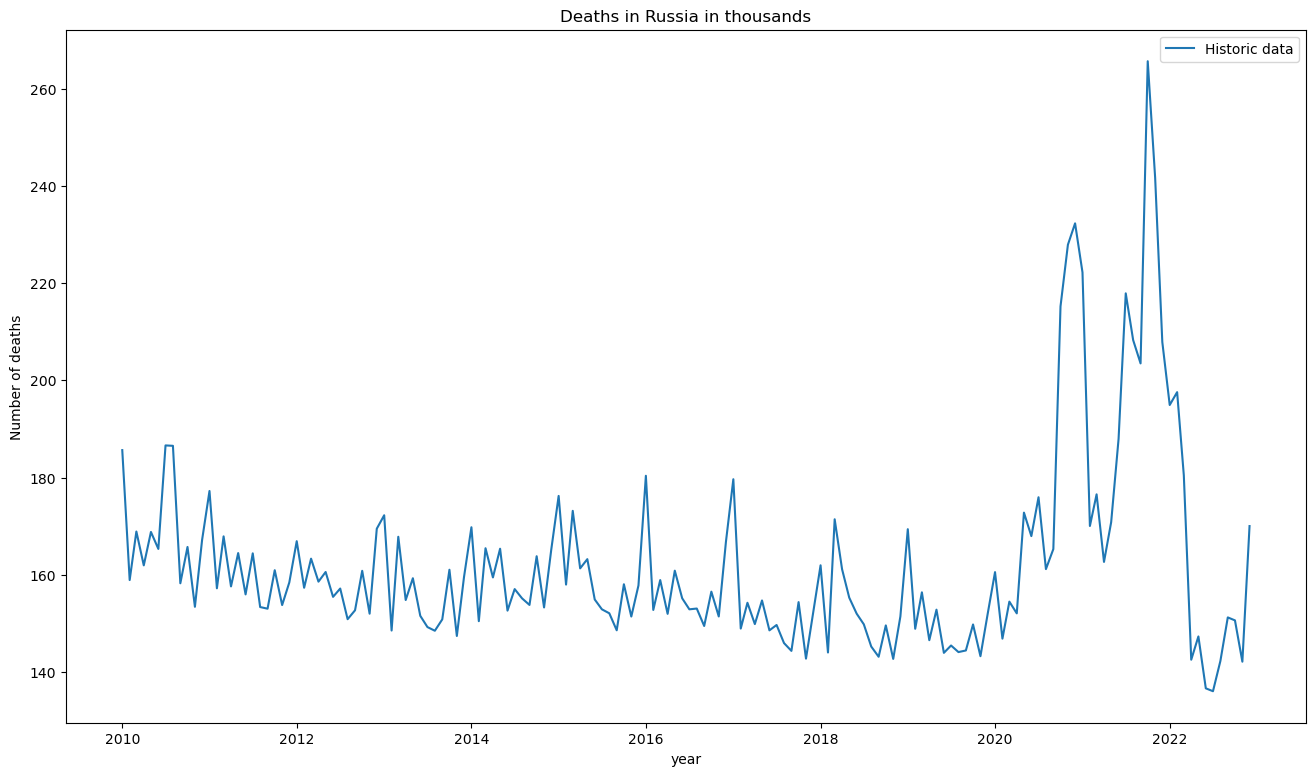

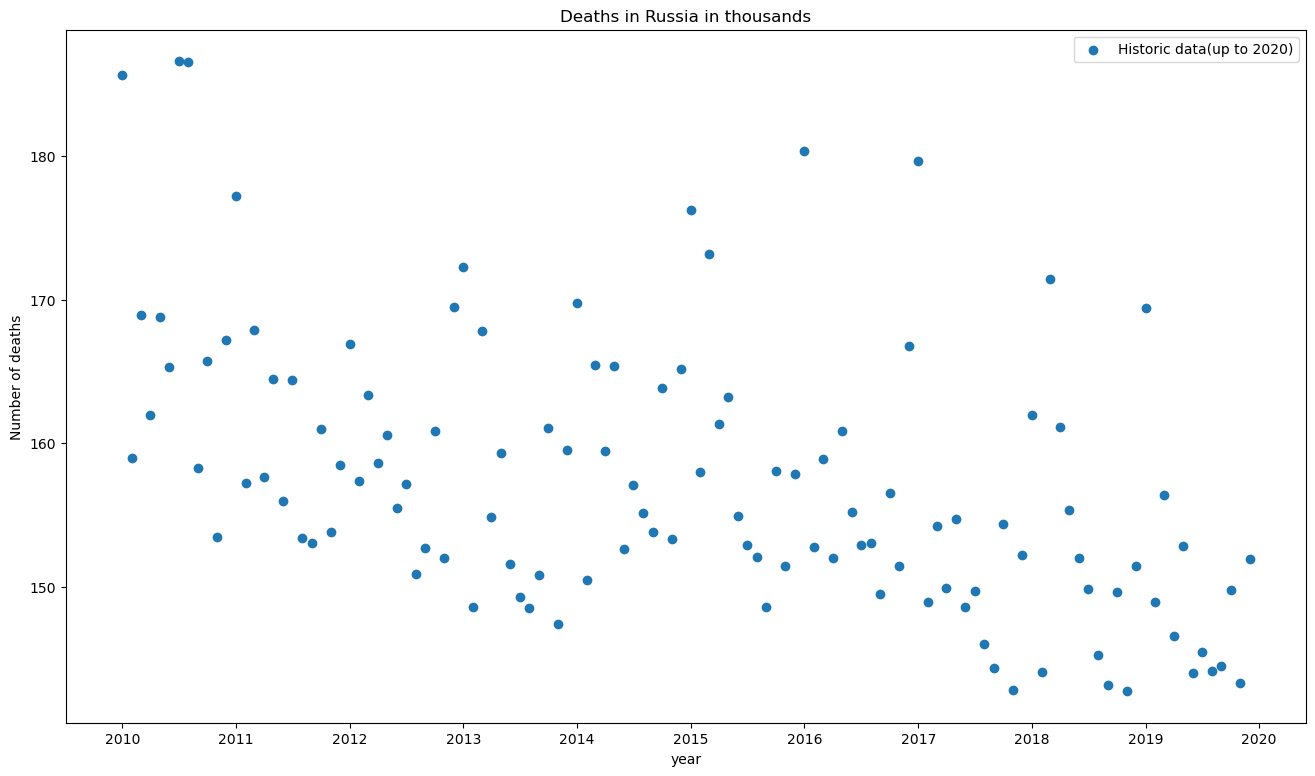

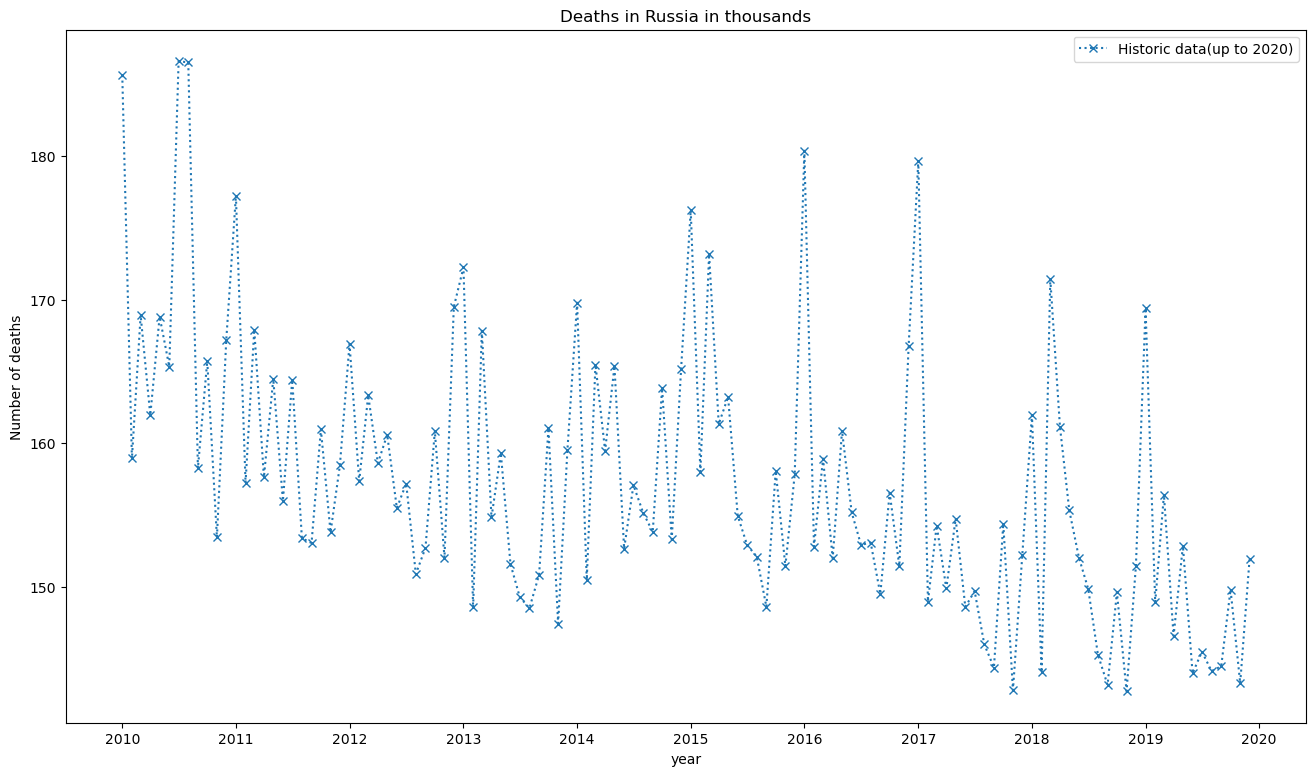

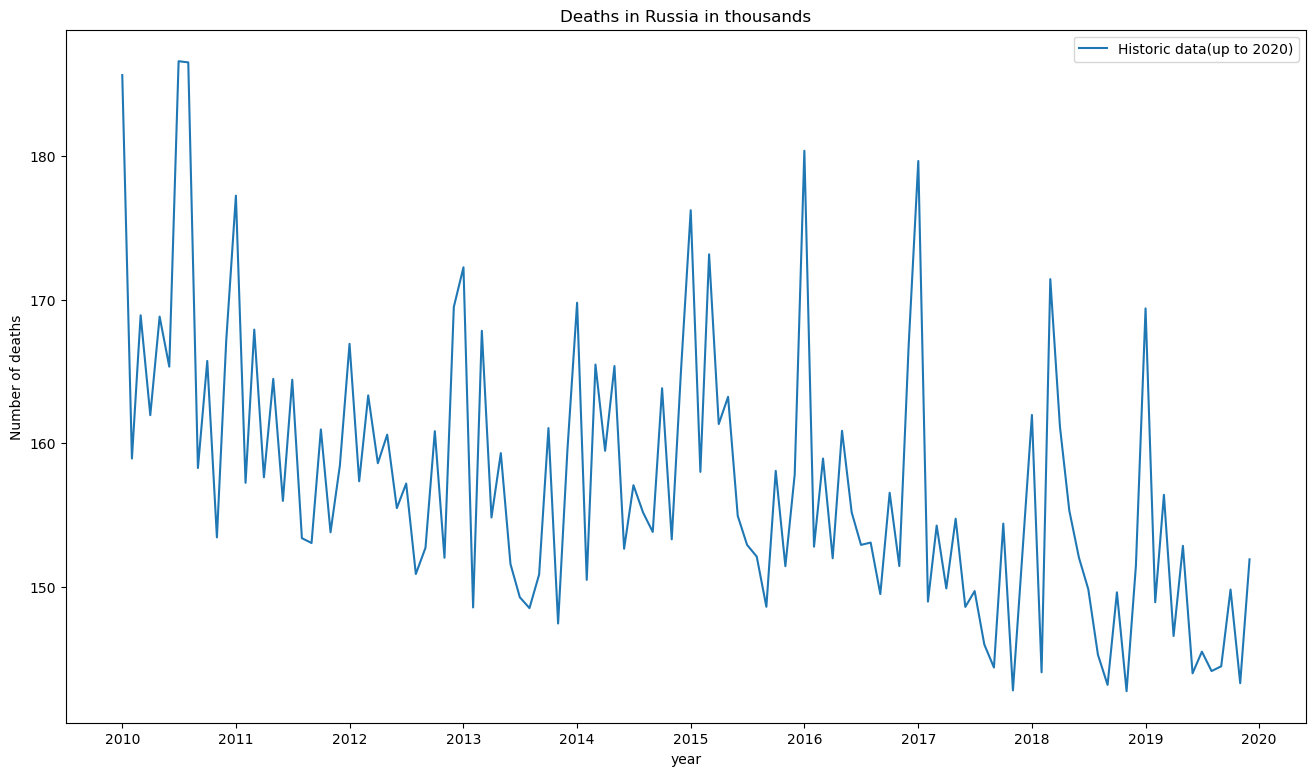

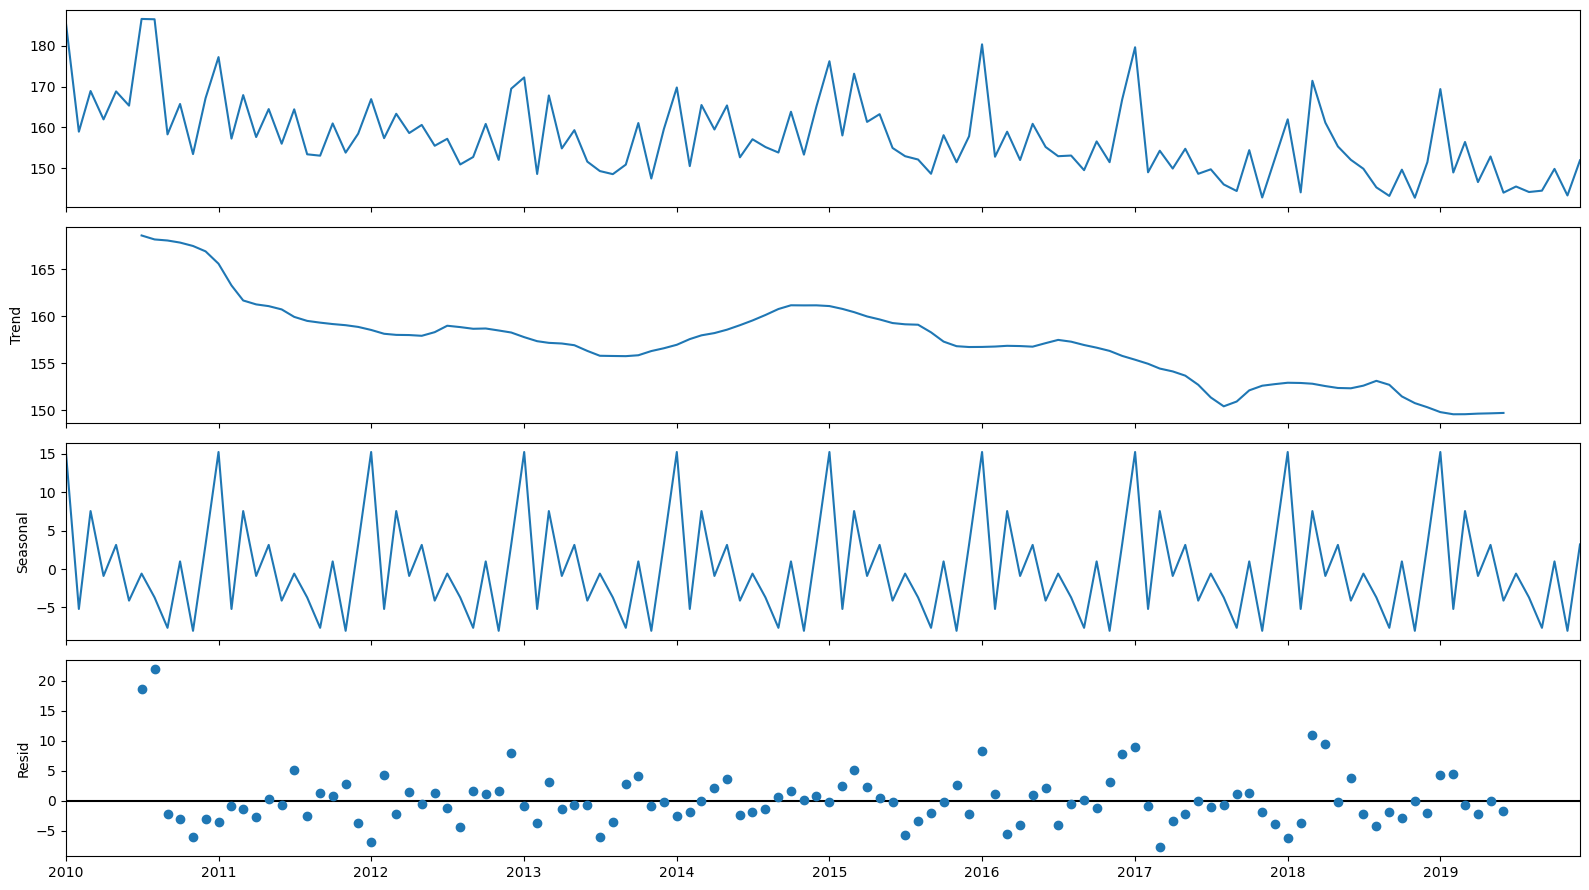

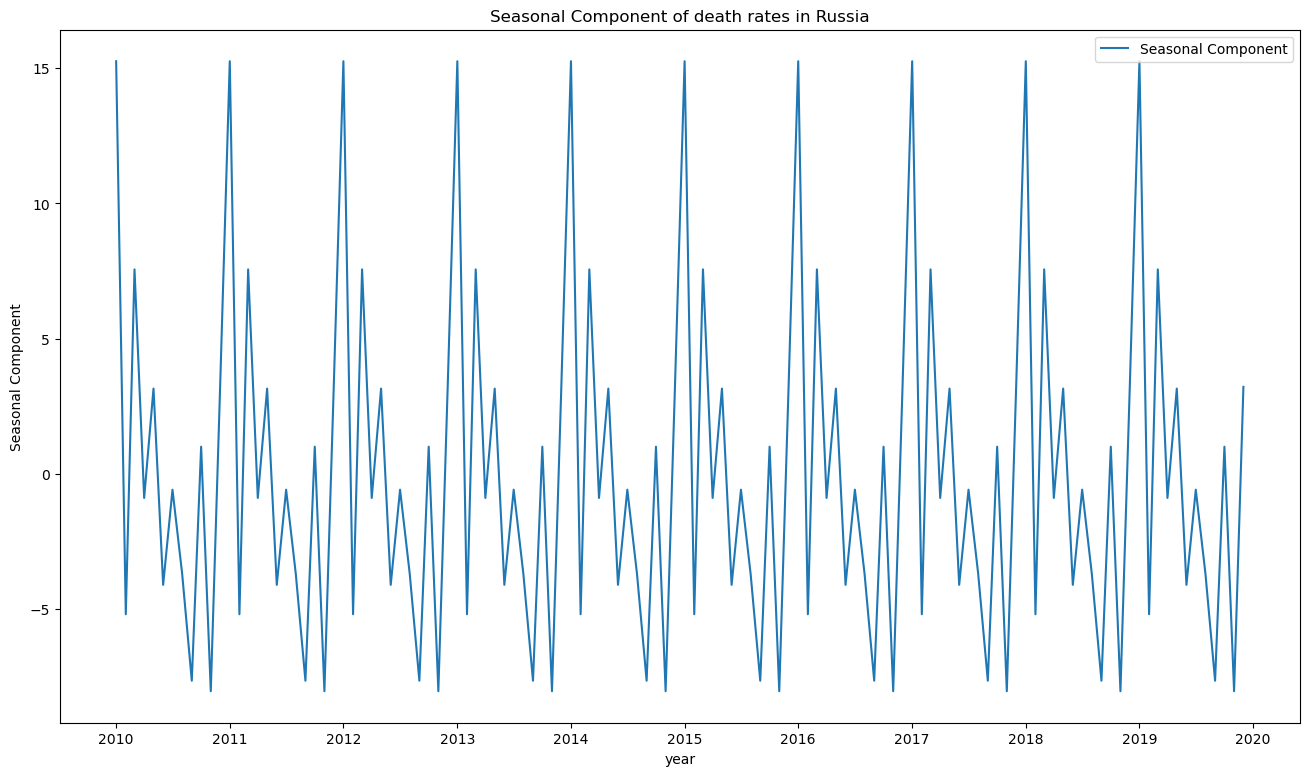

In [525]:
# Данные, которые мы используем, это количество смертей в России по месяцам за 2010-2022, 
# взятые из Демографического ежегодника от Росстата за 2023 и 2017 года.
data = pd.read_csv('ROTTEN.csv', sep = ';')
data['Date'] = data['Date'].apply(lambda x: dt.strptime(x, '%d.%m.%Y'))
data = data.set_index(data['Date']).drop(columns = ['Date'])
data['Number of deaths'] = data['Number of deaths']/1000

plt.figure(figsize=(16, 9))
plt.plot(data, label='Historic data', )
plt.title('Deaths in Russia in thousands')
plt.xlabel('year')
plt.ylabel('Number of deaths')
plt.legend()
plt.show()

# Из-за аномально высокой смертности в 2020-2021 из-за Covid-19 нас следует исключить эти и последующий год
# из статистики для более точной оценки предсказаний
df = data.loc[data.index < '2020-01-01']

# Вывод нескольких типов графиков об историческихз данных
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df['Number of deaths'], label='Historic data(up to 2020)', )
plt.title('Deaths in Russia in thousands')
plt.xlabel('year')
plt.ylabel('Number of deaths')
plt.legend()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(df,":x", label='Historic data(up to 2020)', )
plt.title('Deaths in Russia in thousands')
plt.xlabel('year')
plt.ylabel('Number of deaths')
plt.legend()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(df,linestyle = 'solid', label='Historic data(up to 2020)', )
plt.title('Deaths in Russia in thousands')
plt.xlabel('year')
plt.ylabel('Number of deaths')
plt.legend()
plt.show()

# Проводим разложение временного ряда на составные элементы: тренд, сезонность и шум
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

# Выделяем сезонный компонент, паттерн повторяется каждые 12 месяцев
plt.figure(figsize=(16, 9))
plt.plot(decomposition.seasonal, label='Seasonal Component')
plt.title('Seasonal Component of death rates in Russia')
plt.xlabel('year')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()

In [526]:
# Проводим тест на стационарность данных с помощью теста Дики-Фуллера
result = adfuller(df)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("Ряд стационарен (отклоняем нулевую гипотезу)")
else:
    print("Ряд не стационарен (не отклоняем нулевую гипотезу)")

ADF Statistic: -2.2152034892469814
p-value: 0.2007738134108225
Critical Values:
   1%: -3.4936021509366793
   5%: -2.8892174239808703
   10%: -2.58153320754717
Ряд не стационарен (не отклоняем нулевую гипотезу)


Ряд нестационарен, в слудующих ячейках кода в параметрах модели указываем необходимость привидения ряда к стационарности(use_boxcox=True; enforce_stationarity=True)

# Gradient Boosting

In [527]:
# Функция для создания таблицы признаков с лагами
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for lag in lags:
        lagged_df[f'lag_{lag}'] = lagged_df['Number of deaths'].shift(lag)
    return lagged_df.dropna()

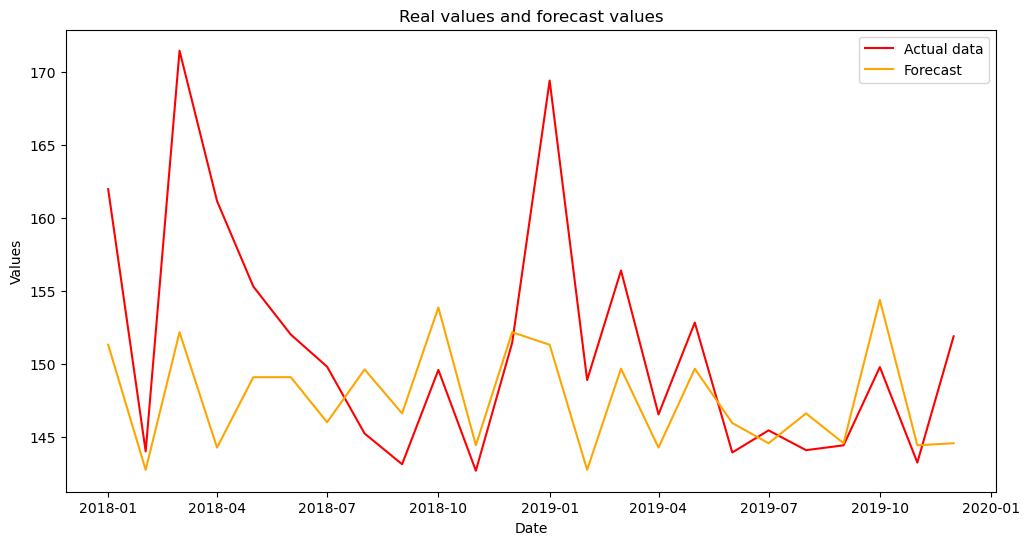

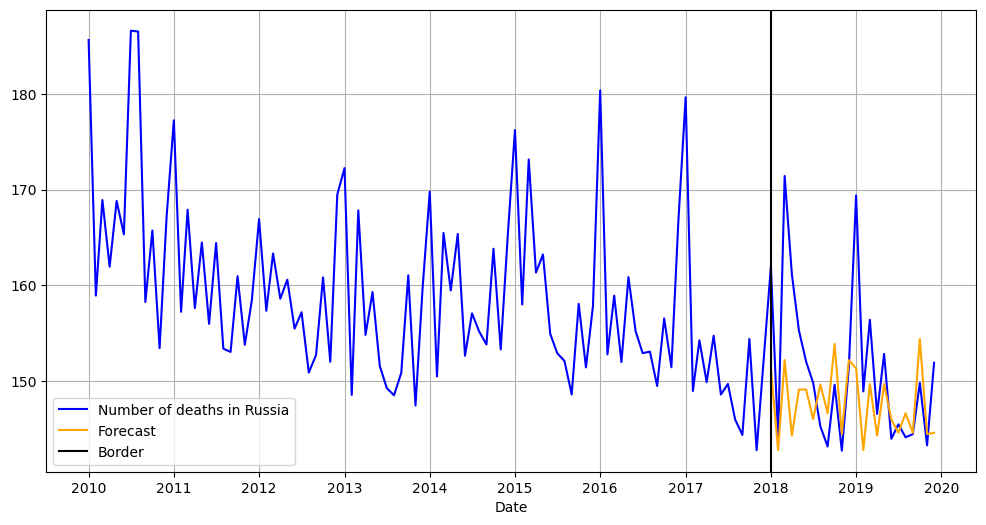

Mean Squared Error: 58.15


In [528]:
# Задаем лаги
lags = [1, 2, 3, 4, 5, 10, 11, 12, 24, 25, 26, 30, 60, 84, 90]
lagged_df = create_lagged_features(df, lags)

# Отделяем предикторы (X) и целевую переменную (y)
X = lagged_df.drop(columns=['Number of deaths'])
y = lagged_df['Number of deaths']

# Разделяем данные на обучающую и тестовую выборки. Прогнозирование будет осуществляться на два года вперёд
border = '2018-01-01'
X_train = X.loc[X.index < border]
y_train = y.loc[y.index < border]
X_test = X.loc[X.index >= border]
y_test = y.loc[y.index >= border]

# Обучение модели
model = XGBRegressor(objective='reg:squarederror', n_estimators=500)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация результатов 2018-2019
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual data', color='red')
plt.plot(y_test.index, y_pred, label='Forecast', color='orange')
plt.title('Real values and forecast values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


# Визуализируем все данные
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Number of deaths'], label='Number of deaths in Russia', color='blue')
plt.plot(y_test.index, y_pred, label='Forecast', color='orange')
plt.xlabel('Date')
plt.axvline(x=border, label='Border', color = 'black')
plt.legend()
plt.grid()
plt.show()

# Оценка модели
forecast_values = y_pred
actual_values = y_test.values
mse_XG = ((actual_values - forecast_values)** 2).mean()
print(f'Mean Squared Error of Gradient Boosting: {round(mse_XG, 2)}')

# ETS model

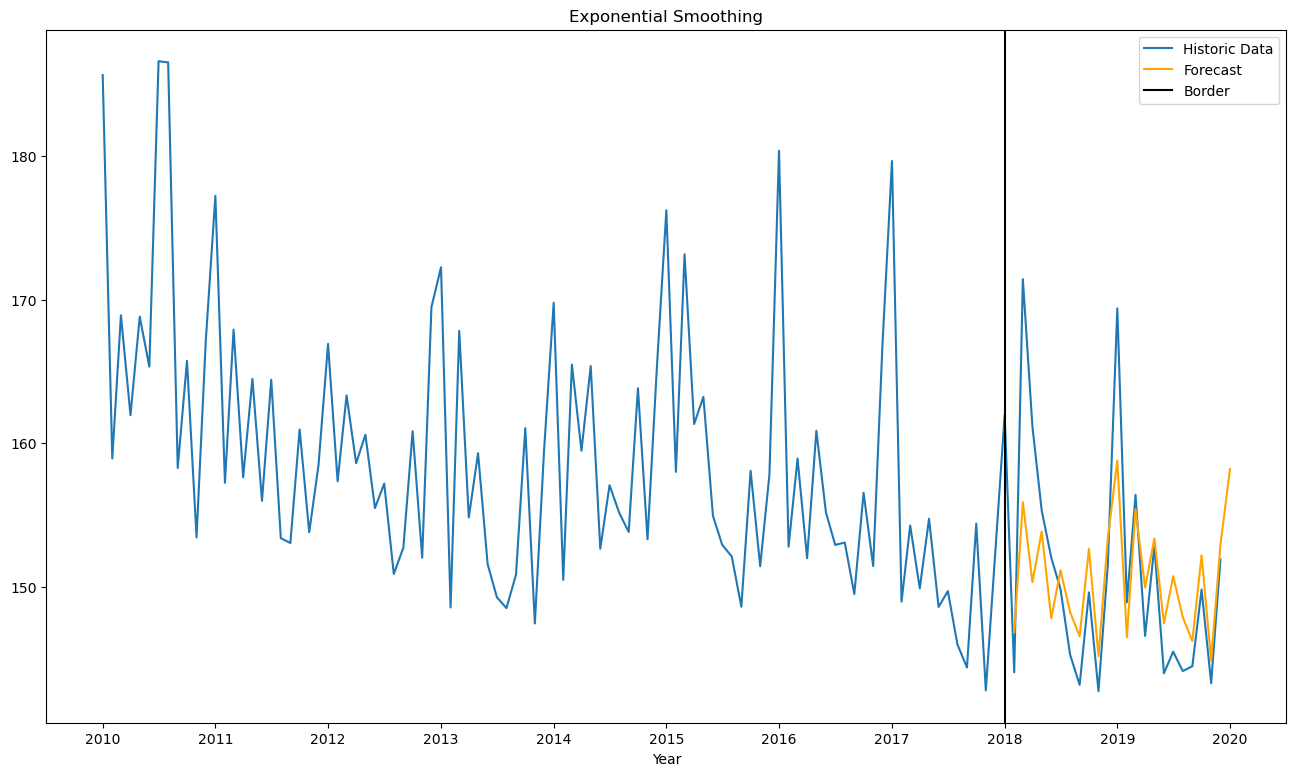

Mean Squared Error: 78.4
Optimal specification of Holt-Winter model: M trend and A seasonality


In [529]:
# Разделяем исторические данные на обучающую и тестовую выборку
df_train = df.loc[df.index <= border]
df_test = df.loc[df.index >= border]

# Запускаем несколько моделей Хольта-Винтера с разными парметрами функции
model_triple_aa = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox = True)
model_triple_am = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal='mul', use_boxcox = True)
model_triple_ma = ExponentialSmoothing(df_train, seasonal_periods=12, trend='mul', seasonal='add', use_boxcox = True)
model_triple_mm = ExponentialSmoothing(df_train, seasonal_periods=12, trend='mul', seasonal='mul', use_boxcox = True)

# Обучаем модель
model_triple_fit_aa = model_triple_aa.fit()
model_triple_fit_am = model_triple_am.fit()
model_triple_fit_ma = model_triple_ma.fit()
model_triple_fit_mm = model_triple_mm.fit()

# Выбираем лучшую конфигурацию модели
forecast_triple_aa = model_triple_fit_aa.forecast(len(df_test))
forecast_triple_am = model_triple_fit_am.forecast(len(df_test))
forecast_triple_ma = model_triple_fit_ma.forecast(len(df_test))
forecast_triple_mm = model_triple_fit_mm.forecast(len(df_test))

# Делаем прогноз
res = {'AA' : forecast_triple_aa, 'AM' : forecast_triple_am, 'MA' : forecast_triple_ma, 'MM' : forecast_triple_mm}
small_mse_ETS = float('inf')
for keys in res.keys():
    forecast_values = res[keys].values
    actual_values = df_test.values
    MSE = ((actual_values - forecast_values)** 2).mean()
    if MSE < small_mse_ETS:
        small_mse_ETS = MSE
        opt_key = keys

# Визуализируем прогноз
plt.plot(df, label='Historic Data')

plt.plot(res[opt_key], label='Forecast', color = 'orange')
plt.xlabel('Year')
plt.title('Exponential Smoothing')
plt.axvline(x=border, label='Border', color = 'black')
plt.legend()
plt.show()

print(f'Mean Squared Error of ETS: {round(small_mse_ETS, 2)}\n'
      f'Optimal specification of Holt-Winter model: {opt_key[0]} trend and {opt_key[1]} seasonality')

# SARIMA model

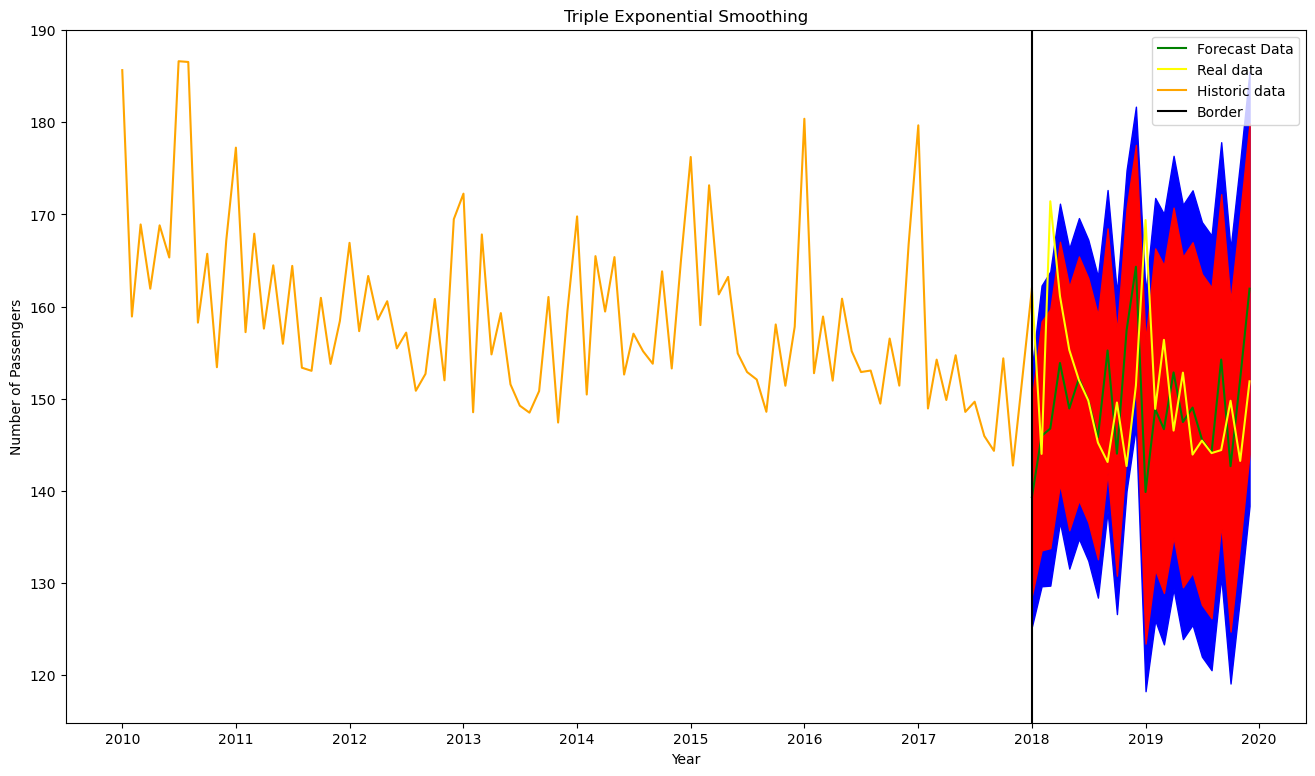

Mean Squared Error: 102.27
Optimal parameters for Sarima: (1, 1, 1, 12)


In [530]:
# Сезонная модификация ARIMA, помимо сезонности, состоит из трёх параметров: порядок авторегрессии, порядок дифференцирования
# и порядок скользящей средней ошибки. Запускаем цикл для определения наилучшей конфигурации
def search_optimal_sarima(time_series, seasonal_cycle, test):
    order_vals = diff_vals = ma_vals = range(0, 3)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    optimal_seasonal_param = None
    small_mse = float('inf')
    
    for seasonal_param in seasonal_combinations:
            sarima_model = sm.tsa.statespace.SARIMAX(time_series,
                                                        seasonal_order=seasonal_param,
                                                        enforce_stationarity=True,
                                                        enforce_invertibility=False, freq = 'MS')
            try:
                model_results = sarima_model.fit()
            except:
                print('Lolo')
                seasonal_combinations.remove(seasonal_param)
                continue
            forecast = model_results.get_forecast(steps = len(test)).predicted_mean
            forecast_values = forecast.values
            actual_values = test.values
            MSE = ((actual_values - forecast_values)** 2).mean()
            if MSE < small_mse:
                optimal_seasonal_param = seasonal_param
                small_mse = MSE

    return optimal_seasonal_param, small_mse
optimal_seasonal_param, small_mse_SARIMA = search_optimal_sarima(df_train, 12, df_test)

# Обучаем модель
dataframe = sm.tsa.statespace.SARIMAX(df_train, seasonal_order=optimal_seasonal_param, enforce_stationarity=True, enforce_invertibility=False).fit()

# Делаем прогноз 
forecast = dataframe.get_forecast(steps = len(df_test))

# Высчитываем доверительный интервал для прогноза для 95% и 99%
conf_int1 = forecast.conf_int(alpha=0.01)
conf_int2 = forecast.conf_int(alpha=0.05)

# Получаем значения прогноза
forecast_values = forecast.predicted_mean

# Визуализируем данные
plt.rcParams ['figure.figsize'] = [16, 9]
plt.plot(df_test.index, forecast_values, label='Forecast Data', color = 'green')

plt.plot(df_test.index, df_test, label='Real data', color = 'yellow')
plt.plot(df_train.index, df_train, label='Historic data', color = 'orange')
plt.axvline(x=border, label='Border', color = 'black')
plt.fill_between(df_test.index, conf_int1.iloc[:, 0], conf_int1.iloc[:, 1], color = 'blue')
plt.fill_between(df_test.index, conf_int2.iloc[:, 0], conf_int2.iloc[:, 1], color = 'red')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.title('Triple Exponential Smoothing')
plt.legend()
plt.show()

print(f'Mean Squared Error of SARIMA: {round(small_mse_SARIMA, 2)}\n'
      f'Optimal parameters for Sarima: {optimal_seasonal_param}')

# Дополнительное сравнение с ожидаемой смертностью в других странах

In [531]:
# В этих двух строках задаётся горизонт прогноза. В данный момент прогнозируется смертность в России в 2023 году
# (от 2018 да 2023 включительно 6 лет, то есть 72 месяца - 1 из-за пересечения дат).
# Для изменения года прогноза нужно поменять количество шагов на количество месяцев с января 2018 до конца прогнозируемого года -1,
# а также изменить год в ссылке


far_future = dataframe.get_forecast(steps = 71).predicted_mean[59:]
url = 'https://database.earth/population/deaths/2023'

# Собираем данные с сайта, посвящённому статистике по смертности в разных странах, а также её прогнозированию 
response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.text)

alls = soup.find_all("tr", {"class" : "even:bg-white odd:bg-gray-100"})[:237]
info = {}
for cos in alls:
    name = cos.find('a').text
    Deaths = float(cos.find_all('td')[2].text.replace(',', ''))/1000
    info[name] = Deaths
table = pd.DataFrame(list(info.items()), columns=['name', 'Deaths'])

# Используем JSON файл для правильной настройки карты
with open('world-countries.json') as json_file:
    state_geo = json.load(json_file)
dash = geopandas.GeoDataFrame.from_features(state_geo, crs = 'EPSG:4326')
data_st = dash.merge(table)

# В данный момент сравниваем количество умерших людей в России за весь 2023 с другими странами. Интервал +- 50%
far_mean = round(far_future.mean(), 2)
far_sum = round(far_future.sum(), 2)
total_st = data_st.loc[(data_st['Deaths'] < far_sum*1.5) &
                    (data_st['Deaths'] > far_sum/1.5)]

In [532]:
# Настраиваем параметры карты
mape = folium.Map(location = [30, 8], zoom_start = 2)

folium.Choropleth(
    geo_data = state_geo,
    name = 'choropleth',
    data=total_st,
    columns = ['name', 'Deaths'],
    key_on = 'properties.name',
    fill_color='YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.8,
    legend_name = 'Deaths(in thousands)',
).add_to(mape)

tooltip = GeoJsonTooltip(
    fields = ['name', 'Deaths'],
    aliases = ['Country', 'Deaths (in thousands)'],
    localize = True,
    sticky = False,
    labels = True,
    style = '''
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    ''',
    max_width = 800,
)

folium.GeoJson(
    total_st,
    style_function = lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    },
    tooltip = tooltip,
    ).add_to(mape)
mape

Получаем страны со сравнимой статистикой смертности за год

In [534]:
print(f'Mean Squared Error of Gradient Boosting: {round(mse_XG, 2)}')
print(f'Mean Squared Error of ETS: {round(small_mse_ETS, 2)}')
print(f'Mean Squared Error of SARIMA: {round(small_mse_SARIMA, 2)}')

Mean Squared Error of Gradient Boosting: 58.15
Mean Squared Error of ETS: 78.4
Mean Squared Error of SARIMA: 102.27


Используем самую эффективную, показательную и простую в использовании метрику для оценки качества предсказаний моделей, MSE. Таким образом, Градиентный бустинг оказался самой подходящей моделью для прогнозирования рассматриваемого временного ряда.

# BONUS

Используем похожий сайт для получения информации о мировой популяции ежей по странам и дополнительной информации о каждой из популяций

In [533]:
url = 'https://worldpopulationreview.com/country-rankings/hedgehog-population-by-country'
response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.text)

alls = soup.find_all('tr', {'class' : 'table-row'})
State = []
Min = []
Max = []
Species = []
Extra = []
for cos in alls:
    name = cos.find('th', {'class' : 'sticky left-0 z-50 bg-clip-padding py-1.5 pl-3 text-left align-middle text-sm text-wpr-table_header md:px-4'}).text
    State.append(name)
    inf = cos.find_all('td', {'class' : 'z-40 px-3 py-1.5 text-sm text-wpr-table_text md:px-4'})
    Min.append(inf[0].text)
    Max.append(inf[1].text)
    Species.append(inf[2].text)
    Extra.append(inf[3].text)
    
info = {'name' : State, 'Min' : Min, 'Max' : Max, 'Species' : Species, 'Extra' : Extra}
table = pd.DataFrame(info)

Estimated = []
Estimated_1M = []
for index in table.index:
    MAX = table.loc[index]['Max']
    if MAX[-1] == 'K':
        MAX = float(MAX[:-1])
    else:
        MAX = float(MAX[:-1])* 1000
    MIN = table.loc[index]['Min']
    if MIN[-1] == 'K':
        MIN = float(MIN[:-1])
    else:
        MIN = float(MIN[:-1])* 1000
    est = estM = int((MAX + MIN)/ 2)
    if est >= 1000:
        est = f'{float(est/ 1000):g}' + 'M'
        estM = estM/ 1000
    else:
        est = f'{float(est):g}' + 'K'
        estM = estM/ 1000
    Estimated.append(est)
    Estimated_1M.append(estM)
    
table['Estimated population'] = Estimated
table['Estimated population(in millions)'] = Estimated_1M

state_geo = requests.get(
    'https://raw.githubusercontent.com/python-visualization/folium-example-data/main/world_countries.json').json()
dash = geopandas.GeoDataFrame.from_features(state_geo, crs = 'EPSG:4326')
data_st = dash.merge(table)
data_st.replace(to_replace='', value='No data',inplace=True)

m = folium.Map(location = [30, 8], zoom_start = 2)

folium.Choropleth(
    geo_data = state_geo,
    name = 'choropleth',
    data=data_st,
    columns = ['name', 'Estimated population(in millions)'],
    key_on = 'properties.name',
    fill_color='GnBu',
    fill_opacity = 0.7,
    line_opacity = 0.8,
    legend_name = 'Estimated Hedgehog population(in millions)',
    bins = [0.1, 0.2, 0.5, 1, 5, 30]
).add_to(m)

popup = GeoJsonPopup(
    fields = ['name', 'Estimated population', 'Min', 'Max', 'Species', 'Extra'],
    aliases = ['Country', 'Estimated population', 'Min population', 'Max population', 'Dominant species', 'Additional info'], 
    localize = True,
    labels = True,
    style = 'background-color: yellow;',
)

tooltip = GeoJsonTooltip(
    fields = ['name', 'Estimated population', 'Min', 'Max'],
    aliases = ['Country', 'Estimated population', 'Min population', 'Max population'],
    localize = True,
    sticky = False,
    labels = True,
    style = '''
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    ''',
    max_width = 800,
)

folium.GeoJson(
    data_st,
    style_function = lambda feature: {
        'fillColor': '#ffff00',
        'color': 'red',
        'weight': 0.2,
        'dashArray': '5, 5'
    },
    tooltip = tooltip,
    popup = popup
    ).add_to(m)
m